# Rudder Kick

Simulate a pilot performing a rudder kick test by inputing a rudder input based
on a ramp input. Aileron input is also included to maintain a steady heading 
sideslip (SHSS). The time histories of the control inputs and beta (sideslip angle)
are plotted.

In [ ]:
# Confirm that JSBSim is installed. If not and running on Google Colab
# then install JSBSim into the Google Colab instance.

import os

try:
  import jsbsim
  print('JSBSim is installed')
  # Relative path to the directory where the flight model is stored
  # Note - Aircraft directory needs to be writeable in order to modify the cg
  PATH_TO_JSBSIM_FILES="../.."
  print(f'Current working directory: {os.getcwd()}')
except ImportError:
  import sys
  if 'google.colab' in sys.modules:
      print('Installing JSBSim...')
      !pip install jsbsim
      # Use the standard aircraft supplied by the JSBSim Python package
      PATH_TO_JSBSIM_FILES=None

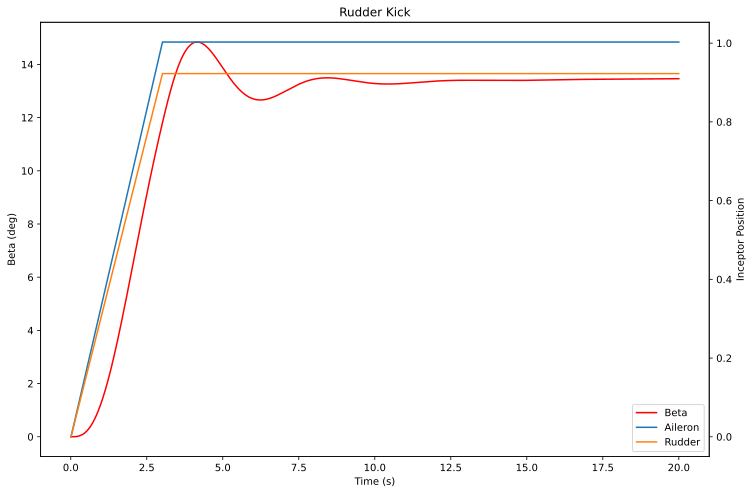

In [ ]:
import jsbsim
import matplotlib.pyplot as plt
import math

# --- Configuration Section ---
# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="737"

# --- JSBSim Initialization ---
# These lines initialize the flight dynamics model.

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Create a flight dynamics model (FDM) instance.
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1


# --- Simulation Parameters ---
# These lines set the simulation parameters.

# Set alpha range for trim solutions
fdm['aero/alpha-max-rad'] = math.radians(12)   # Maximum angle of attack in radians.
fdm['aero/alpha-min-rad'] = math.radians(-4.0) # Minimum angle of attack in radians.

# Get the simulation time step (delta time).
dt = fdm.get_delta_t()

# Max control deflection
aileronMax = 1   # Maximum normarized aileron command (-1~1)
rudderMax = 0.92 # Maximum normarized rudder command (-1~1)

# Number of seconds for control surface to reach max deflection
risetime = 3

# Calculate the increment (change) in control surface deflection command per time step.
diAileron = aileronMax / (risetime/dt)
diRudder = rudderMax / (risetime/dt)


# --- Data Storage ---
# This section initializes lists to record simulation data.

times = []      # List to record the simulation time at each step.
betas = []      # List to record the beta angle at each step.
bankAngle = []  # List to record the bank angle at each step.
ailerons = []   # List to record the aileron control surface deflection.
rudder = []     # List to record the rudder control surface deflection.


# --- Simulation Initialization ---
# This line initializes the flight dynamics model.

# Initial conditions
fdm['ic/h-sl-ft'] = 1000  #altitude above sea level (ft)
fdm['ic/vc-kts'] = 200    #calibrated airspeed (kts)
fdm['ic/gamma-deg'] = 0   #flight path angle (deg)
fdm['ic/beta-deg'] = 0    #sideslip angle (deg)

# Initialize the aircraft with initial conditions
fdm.run_ic()

# Attempt to trim the aircraft.
try:
    # 1 means straight flight by using all changeable control variables.
    fdm['simulation/do_simple_trim'] = 1

except jsbsim.TrimFailureError:
    print("Trim failed, continuing rudder kick in an untrimmed state.")
    pass  # Ignore trim failure


# --- Simulation Loop ---
# This is the main simulation loop that runs the simulation for a specified duration.

# Time to run for in seconds.
run_period = 20

for i in range(int(run_period/dt)):
    # Advance the simulation by one time step.
    fdm.run()

    # Record the simulation data.
    times.append(fdm.get_sim_time())
    betas.append(fdm['aero/beta-deg'])
    bankAngle.append(fdm['attitude/phi-deg'])
    ailerons.append(fdm['fcs/aileron-cmd-norm'])
    rudder.append(fdm['fcs/rudder-cmd-norm'])

    # Control Surface Update
    aileronCmd = fdm['fcs/aileron-cmd-norm']
    rudderCmd = fdm['fcs/rudder-cmd-norm']

    # Increment the aileron command if it's less than the maximum.
    if aileronCmd < aileronMax:
        aileronCmd += diAileron
        fdm['fcs/aileron-cmd-norm'] = aileronCmd

    # Increment the rudder command if it's less than the maximum.
    if rudderCmd < rudderMax:
        rudderCmd += diRudder
        fdm['fcs/rudder-cmd-norm'] = rudderCmd


# --- Plot Results ---
# This section plots the simulation results.

plt.rcParams["figure.figsize"] = (12, 8) # Set the figure size.
fig, ax1 = plt.subplots()

# Plot the beta data on the primary y-axis.
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Beta (deg)')
line1 = ax1.plot(times, betas, label='Beta', color='red')

# Create a secondary y-axis for the control surface positions.
ax2 = ax1.twinx()

# Plot the aileron and rudder commands on the secondary y-axis.
ax2.set_ylabel('Inceptor Position')
line2 = ax2.plot(times, ailerons, label='Aileron')
line3 = ax2.plot(times, rudder, label='Rudder')

# Add a legend to the plot.
ax1.legend(handles=line1+line2+line3, loc=4)

# Set the title of the plot.
plt.title('Rudder Kick')

# Display the plot.
plt.show()